# Debugging in tyssue

In [36]:
import pandas as pd
import numpy as np
import json
import matplotlib.pylab as plt
%matplotlib inline

from tyssue import Sheet, Monolayer, config
from tyssue import SheetGeometry, PlanarGeometry


# What we're here for
from tyssue.topology.sheet_topology import type1_transition
from tyssue.topology.base_topology import collapse_edge, remove_face
from tyssue.topology.sheet_topology import split_vert as sheet_split
from tyssue.topology.bulk_topology import split_vert as bulk_split
from tyssue.topology import condition_4i, condition_4ii

## model and solver
from tyssue.dynamics.sheet_vertex_model import SheetModel as model
from tyssue.solvers.quasistatic import QSSolver
from tyssue.generation import extrude
from tyssue.dynamics import model_factory, effectors

# 2D plotting
from tyssue.draw import sheet_view, highlight_cells, highlight_faces

#I/O
from tyssue.io import hdf5
plt.style.use('bmh')

import logging
geom = SheetGeometry

## Use `%pdb`

This is the classical python debugger, read more [here](https://docs.python.org/3/library/pdb.html)

%pdb

```python
1 / 0
```

## Get log messages and set log level

In [37]:
log = logging.getLogger("tyssue")
log.setLevel("DEBUG")
hand = logging.StreamHandler()
hand.setLevel("DEBUG")
log.addHandler(hand)


## Display indices, highlight faces

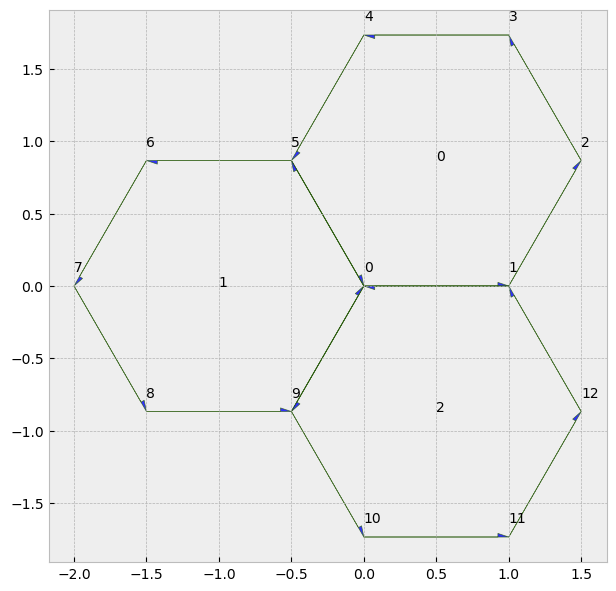

In [38]:
from tyssue.generation import three_faces_sheet

sheet = Sheet('3f', *three_faces_sheet())
geom.update_all(sheet)
fig, ax = sheet_view(sheet, edge={'head_width': 0.05})
fig.set_size_inches(8, 8)

# This can be long for a big (Nf > 100) eptm
for face, data in sheet.face_df.iterrows():
    ax.text(data.x, data.y, face)
    
for vert, data in sheet.vert_df.iterrows():
    ax.text(data.x, data.y+0.1, vert)



reseting index for sub
Resetting topology
reseting index for sub_copy


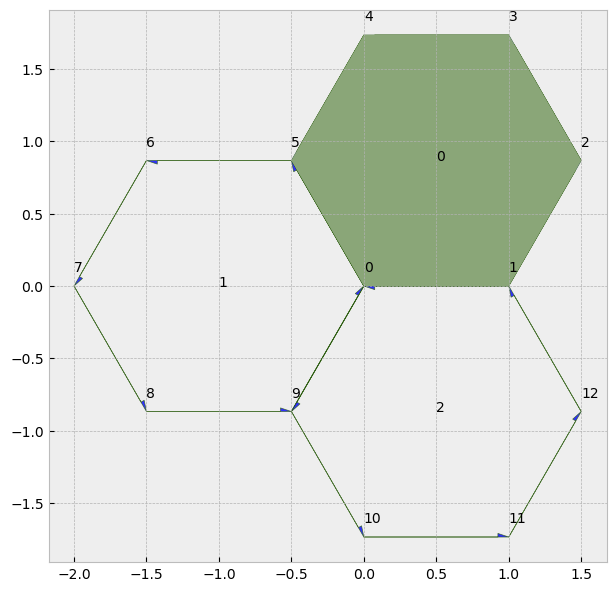

In [10]:

highlight_faces(sheet.face_df, [0,], reset_visible=True)

fig, ax = sheet_view(sheet, edge={'head_width': 0.05}, face={'visible': True})
fig.set_size_inches(8, 8)
for face, data in sheet.face_df.iterrows():
    ax.text(data.x, data.y, face)

for vert, data in sheet.vert_df.iterrows():
    ax.text(data.x, data.y+0.1, vert)

### Use `validate` to check the topology is correct 

In [11]:
sheet.validate()

True

### Create a small patch of cells in 2D and a simple mechanical model

In [13]:
print("dangling trgt:", set(sheet.vert_df.index).difference( set(sheet.edge_df.trgt)))
print("dangling srce:", set(sheet.vert_df.index).difference( set(sheet.edge_df.srce)))



dangling trgt: set()
dangling srce: set()


In [14]:
sheet.edge_df.query("face == 5")

,srce,trgt,face,dx,dy,dz,nx,ny,nz,sx,...,is_active,ux,uy,uz,rx,ry,rz,sub_area,sub_vol,is_valid
edge,,,,,,,,,,,,,,,,,,,,,


In [34]:
sheet = Sheet.planar_sheet_2d('flat', 30, 30, 1, 1, noise=0.001)
geom = PlanarGeometry

to_cut = sheet.cut_out([(0.1, 6), (0.1, 6)])
sheet.remove(to_cut, trim_borders=True)
sheet.sanitize(trim_borders=True)
geom.center(sheet)
geom.update_all(sheet)
sheet.update_rank()

model = model_factory(
    [
        effectors.LineTension,
        effectors.FaceContractility,
        effectors.FaceAreaElasticity
    ]
)

specs = {
    "face": {
        "contractility": 5e-2,
        "prefered_area": sheet.face_df.area.mean(),
        "area_elasticity": 1.
    },
    "edge": {
        "line_tension": 1e-2,
        "is_active": 1
    },
    "vert": {
        "is_active": 1
    },
}

sheet.update_specs(specs, reset=True)

Removing cells at the face level
876 face level elements will be removed
reseting index for flat
Resetting topology
closing face 0
closing face 1
closing face 2
closing face 3
closing face 4
closing face 5
closing face 6
closing face 7
closing face 8
closing face 9
closing face 14
closing face 15
closing face 19
reseting index for flat
Resetting topology
reseting index for flat
Resetting topology
Reseting column is_active of the vert dataset with new specs


In [16]:
print("dangling trgt:", set(sheet.vert_df.index).difference( set(sheet.edge_df.trgt)))
print("dangling srce:", set(sheet.vert_df.index).difference( set(sheet.edge_df.srce)))



dangling trgt: set()
dangling srce: set()


### Gradient descent

initial number of vertices: 46
set pos
set pos
set pos
set pos
set pos
set pos
set pos
set pos
set pos
set pos
set pos
set pos
set pos
set pos
set pos
set pos
set pos
set pos
set pos
set pos
set pos
set pos
set pos
set pos
set pos
set pos
set pos
set pos
set pos
set pos
set pos
set pos
set pos
set pos
set pos
set pos
set pos
set pos
set pos
set pos
set pos
set pos
set pos
set pos
set pos
set pos
set pos
set pos
set pos
set pos
set pos
set pos
set pos
set pos
set pos
set pos
final number of vertices: 46


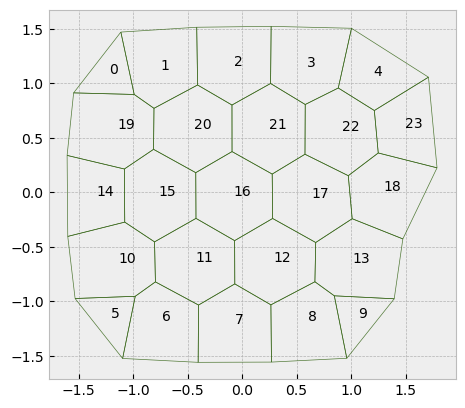

In [18]:
solver = QSSolver()

res = solver.find_energy_min(sheet, geom, model)

fig, ax = sheet_view(sheet)
for f, (x, y) in sheet.face_df[["x", "y"]].iterrows():
    ax.text(x, y, f)


### Remove a vertex from vert_df to create an invalid sheet


**TODO** That does not fail. We "just" get a polynucleated cell ^^'

In [39]:
v = np.random.choice(sheet.vert_df.index)

sheet.vert_df.drop([v,], axis=0, inplace=True)

In [40]:
set(sheet.edge_df.trgt) == set(sheet.vert_df.index)

False

In [41]:
sheet.validate()

True

In [42]:
sheet.reset_index()

reseting index for 3f
reseting index for 3f


In [43]:
sheet.validate()

True

In [44]:
set(sheet.edge_df.trgt) == set(sheet.vert_df.index)

True

In [23]:
geom.update_all(sheet)

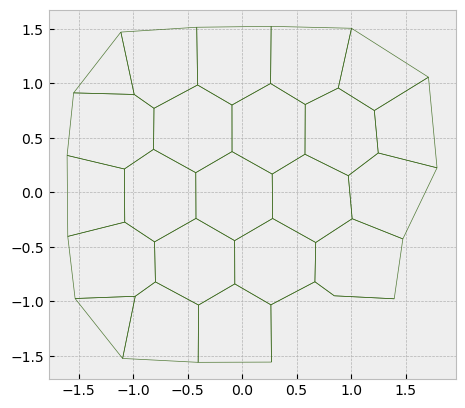

In [24]:
fig, ax = sheet_view(sheet)


In [25]:
bad_edges = sheet.edge_df[sheet.get_invalid()]

In [33]:
bad_edges

,trgt,nz,length,face,srce,dx,dy,sx,sy,tx,ty,fx,fy,ux,uy,is_valid,rx,ry,sub_area
edge,,,,,,,,,,,,,,,,,,,
